# Remoção da Tendência Temporal
Primeiro avaliamos transformações para remover tendência das séries semanais de `volume`, `inv` e `users`.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from model.data_loader import CSVDataLoader
from model.preprocessor import LogTransform, LogDiffTransform
from model.evaluator import TimeSeriesEvaluator, TransformEvaluator

plt.style.use("seaborn-v0_8")


Carregamos o dataset e começamos observando as séries originais. Percebe-se que, especialmente para `volume`, há **alta variabilidade**: quando os níveis da série crescem, a amplitude das oscilações também aumenta. Esse comportamento sugere um componente **multiplicativo**, para o qual uma transformação de **log** é adequada para estabilizar a variância.

In [4]:
data_path = "data/data_updated.csv"
loader = CSVDataLoader(file_path=data_path, date_column="week")

df = loader.load().sort_values("week")

series_names = ["volume", "inv", "users"]
series_dict = {name: df[name].astype(float) for name in series_names}

df[series_names].head()


,volume,inv,users
week,,,
2022-10-31,0.38,1.609882,6.500
2022-11-07,0.47,1.880548,7.061
2022-11-14,0.32,2.297810,5.875
2022-11-21,1.69,5.623875,24.238
2022-11-28,1.23,1.473418,7.648


Primeiro olhamos o formato de cada uma das séries consideradas. Está bastante claro, em especial para a série de `volume`, que há forte autocorrelação e também grande variação na amplitude ao longo do tempo.

Isso motiva o uso de uma **transformação logarítmica** para estabilizar a variância antes de aplicar transformações adicionais para remover tendência.

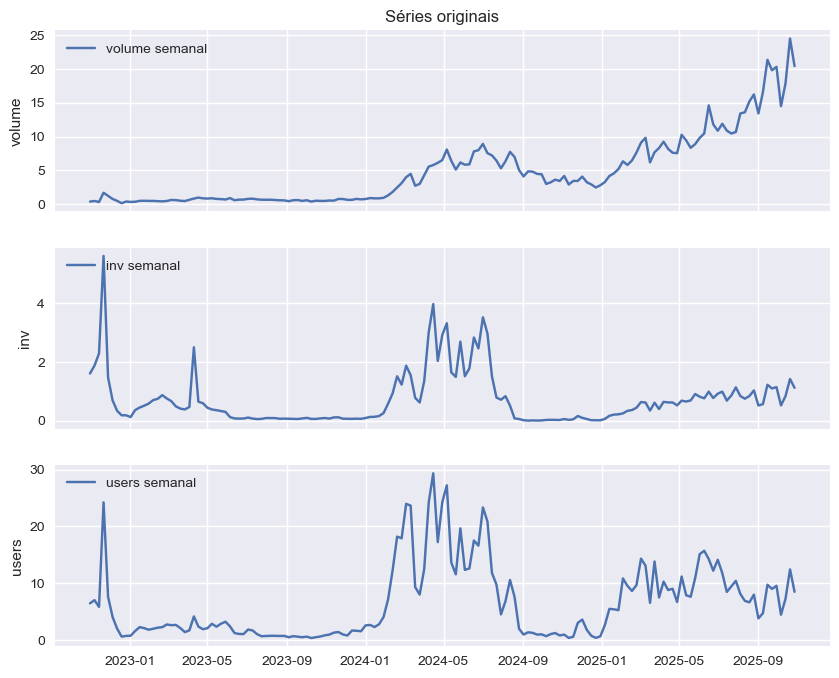

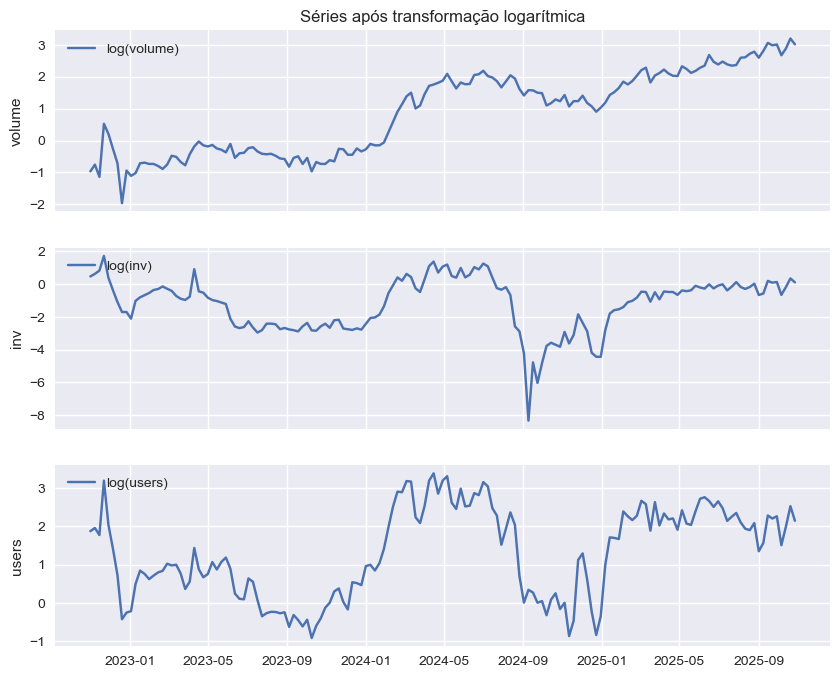

In [5]:
fig, axes = plt.subplots(len(series_names), 1, figsize=(10, 8), sharex=True)
for ax, name in zip(axes, series_names):
    ax.plot(series_dict[name], label=f"{name} semanal")
    ax.set_ylabel(name)
    ax.legend(loc="upper left")
axes[0].set_title("Séries originais")
plt.show()

# Aplicamos a transformação logarítmica para estabilizar a variância
log_transformer = LogTransform()
log_series_dict = {}
for name in series_names:
    y = series_dict[name].astype(float).values
    y_log = log_transformer.transform(y)
    log_series_dict[name] = pd.Series(y_log, index=series_dict[name].index)

fig, axes = plt.subplots(len(series_names), 1, figsize=(10, 8), sharex=True)
for ax, name in zip(axes, series_names):
    ax.plot(log_series_dict[name], label=f"log({name})")
    ax.set_ylabel(name)
    ax.legend(loc="upper left")
axes[0].set_title("Séries após transformação logarítmica")
plt.show()


Criamos, então, um **avaliador** para medir a qualidade de uma transformação no conjunto de dados, na medida em que ela consegue deixar a série mais próxima de uma série estacionária. Internamente, ele aplica o teste *Augmented Dickey-Fuller (ADF)*, que é comumente usado para testar justamente essa característica.

Note que o teste ADF verifica apenas **estacionariedade**; para investigar se ainda há **autocorrelação significativa**, também vamos inspecionar os gráficos de **função de autocorrelação (ACF)** antes e depois das transformações.

In [6]:
transform_evaluator = TransformEvaluator()

transforms = []


Nesse caso, consideraremos duas etapas de transformação:

1. **Transformação logarítmica**: usada principalmente para **estabilizar a variância** nas séries (reduz a dependência da variância em relação ao nível da série).

2. **Diferença**: aplicada após o log, com o objetivo de **remover a tendência** remanescente e aproximar a série de um processo estacionário.

In [7]:
# Implementamos as mesmas ideias usando as classes de pré-processamento
logdiff_series_dict = {}

for series_name, series in series_dict.items():
    # Diferença simples em escala original (para comparação)
    diff_series = series.diff().dropna()

    # Diferença do log usando o método em model/preprocessor.py
    logdiff_transformer = LogDiffTransform()
    y = series.astype(float).values
    y_logdiff = logdiff_transformer.transform(y)
    logdiff_series = pd.Series(y_logdiff, index=series.index[1:])  # perde a primeira observação

    # Salvamos para análise posterior
    if series_name not in logdiff_series_dict:
        logdiff_series_dict[series_name] = {}
    logdiff_series_dict[series_name]["Diferença de primeira ordem"] = diff_series
    logdiff_series_dict[series_name]["Diferença do log(x)"] = logdiff_series

    # Avaliamos com o teste ADF
    transforms.append(
        transform_evaluator.evaluate(diff_series, "Diferença de primeira ordem", series_name)
    )
    transforms.append(
        transform_evaluator.evaluate(logdiff_series, "Diferença do log(x)", series_name)
    )


In [8]:
results = pd.DataFrame(transforms).sort_values(["series", "p_value"])
results


,series,transform,p_value,test_stat,n_obs
3,inv,Diferença do log(x),1.947030e-26,-14.178507,155
2,inv,Diferença de primeira ordem,8.077797e-23,-12.284635,154
5,users,Diferença do log(x),4.227659e-18,-10.261388,154
4,users,Diferença de primeira ordem,2.878416e-12,-7.965139,152
1,volume,Diferença do log(x),2.549212e-07,-5.917731,151
0,volume,Diferença de primeira ordem,4.020645e-06,-5.364465,151


Avaliando os p-valores, temos que a diferença do logaritmo parece ser a melhor transformação.

In [9]:
best_per_series = (
    results.sort_values("p_value").groupby("series").first().reset_index()
)
for _, row in best_per_series.iterrows():
    print(
        f"Série {row.series}: {row.transform} -> p-valor {row.p_value:.4f}, estatística {row.test_stat:.3f}"
    )

best_per_series


Série inv: <bound method Series.transform of series                       inv
transform    Diferença do log(x)
p_value                      0.0
test_stat             -14.178507
n_obs                        155
Name: 0, dtype: object> -> p-valor 0.0000, estatística -14.179
Série users: <bound method Series.transform of series                     users
transform    Diferença do log(x)
p_value                      0.0
test_stat             -10.261388
n_obs                        154
Name: 1, dtype: object> -> p-valor 0.0000, estatística -10.261
Série volume: <bound method Series.transform of series                    volume
transform    Diferença do log(x)
p_value                      0.0
test_stat              -5.917731
n_obs                        151
Name: 2, dtype: object> -> p-valor 0.0000, estatística -5.918


,series,transform,p_value,test_stat,n_obs
0,inv,Diferença do log(x),1.947030e-26,-14.178507,155
1,users,Diferença do log(x),4.227659e-18,-10.261388,154
2,volume,Diferença do log(x),2.549212e-07,-5.917731,151


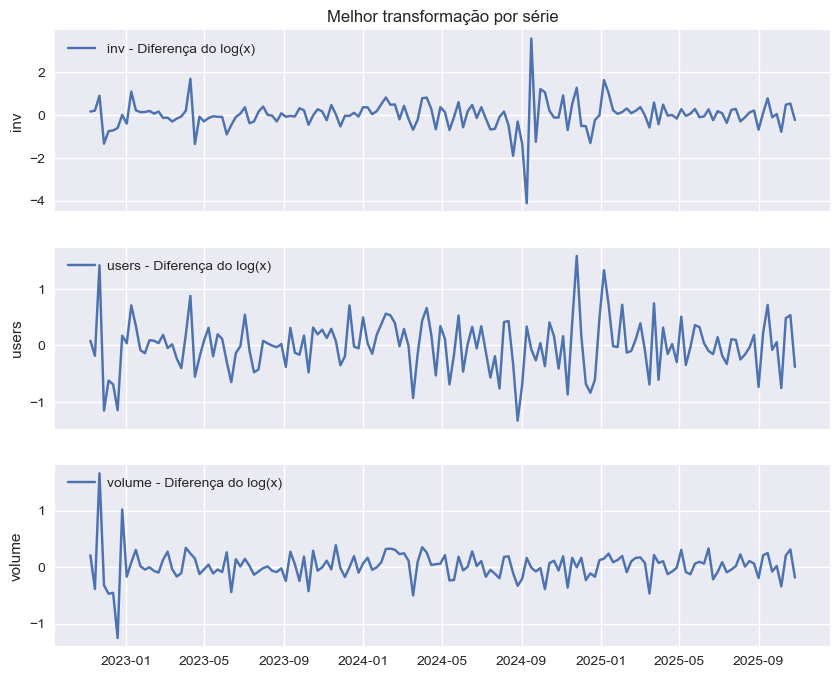

In [13]:
fig, axes = plt.subplots(len(best_per_series), 1, figsize=(10, 8), sharex=True)
axes = np.atleast_1d(axes)
for ax, row in zip(axes, best_per_series.itertuples()):
    best_series = logdiff_series_dict[row.series][row.transform]
    ax.plot(best_series, label=f"{row.series} - {row.transform}")
    ax.set_ylabel(row.series)
    ax.legend(loc="upper left")
axes[0].set_title("Melhor transformação por série")
plt.show()


Agora avaliamos a **autocorrelação** antes e depois da transformação de log-diferença.

A ideia é verificar se a transformação não só torna a série estacionária segundo o ADF, mas também **reduz a autocorrelação** em defasagens mais altas, o que é desejável para muitos modelos de série temporal.


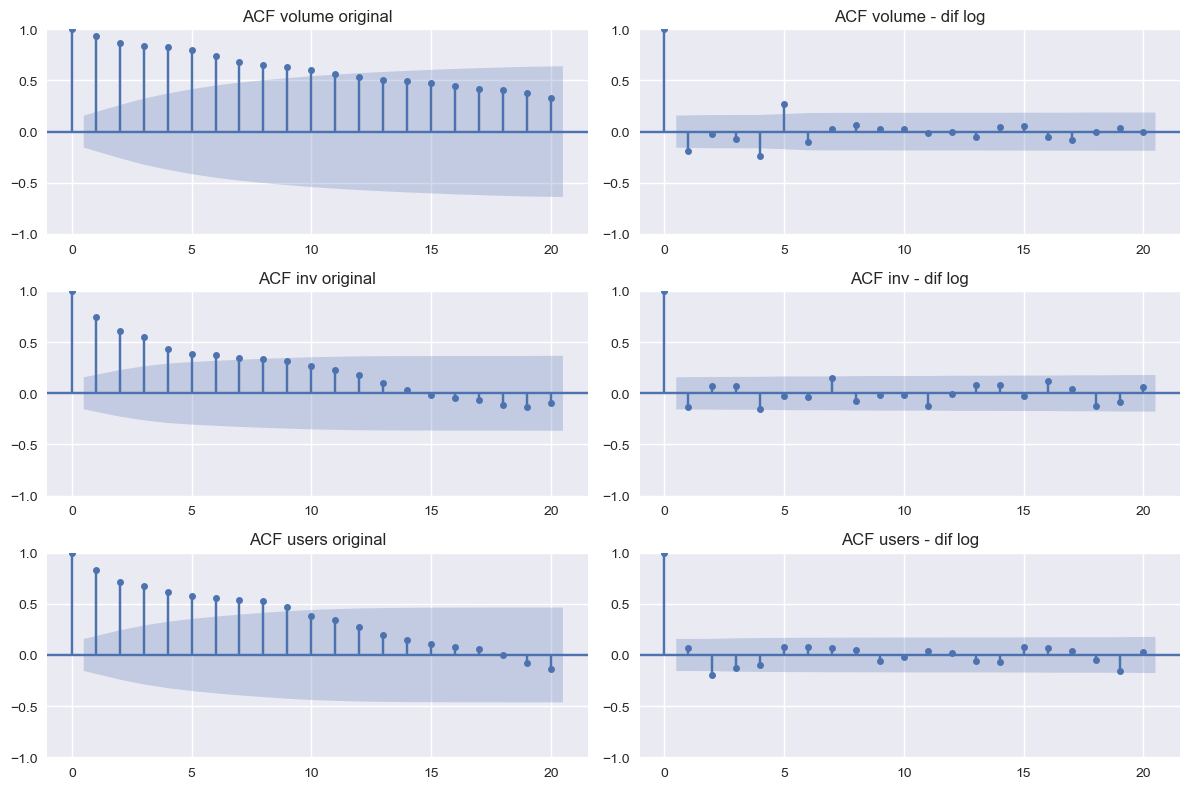

In [14]:
fig, axes = plt.subplots(len(series_names), 2, figsize=(12, 8))

for i, name in enumerate(series_names):
    # Série original
    plot_acf(series_dict[name].dropna(), ax=axes[i, 0], lags=20)
    axes[i, 0].set_title(f"ACF {name} original")

    # Série transformada (diferença do log)
    transformed = logdiff_series_dict[name]["Diferença do log(x)"].dropna()
    plot_acf(transformed, ax=axes[i, 1], lags=20)
    axes[i, 1].set_title(f"ACF {name} - dif log")

plt.tight_layout()
plt.show()



Após a transformação, observa-se que a autocorrelação nas primeiras defasagens **diminui consideravelmente** em todas as séries, especialmente em defasagens elevadas, indicando redução da memória de longo prazo. Isso sugere que a transformação de diferença do log foi **efetiva** em eliminar tendências e tornar as séries mais próximas de estacionárias, já que a maioria das autocorrelações rapidamente se aproxima de zero após poucos lags. 

In [10]:
from model.preprocessor import LogDiffTransform
from model.ar_ma_models import ARModel, MAModel

def select_ar_model(y: np.ndarray, max_lags: int = 10) -> ARModel:
    best_model = None
    best_aic = np.inf
    for p in range(1, max_lags + 1):
        diff_ar = LogDiffTransform()
        y_train_diff = diff_ar.transform(y)
        model = ARModel(lags=p)
        model.fit(y_train_diff)
        if model.get_params().get("aic", np.inf) < best_aic:
            best_aic = model.get_params().get("aic", np.inf)
            best_model = model
    return best_model


def select_ma_model(y: np.ndarray, max_order: int = 10) -> MAModel:
    best_model = None
    best_aic = np.inf
    for q in range(1, max_order + 1):
        diff_ma = LogDiffTransform()
        y_train_diff = diff_ma.transform(y)
        model = MAModel(order=q)
        model.fit(y_train_diff)
        if model.get_params().get("aic", np.inf) < best_aic:
            best_aic = model.get_params().get("aic", np.inf)
            best_model = model
    return best_model

In [11]:
def train_test_split(y: np.ndarray, test_size: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Divide a série em treino e teste usando o último 'test_size' pontos como teste.
    """
    if test_size <= 0 or test_size >= len(y):
        raise ValueError("test_size deve ser > 0 e < len(y)")
    return y[:-test_size], y[-test_size:]

y_train, y_test = train_test_split(y, test_size=12)

In [16]:
from model.visualizer import TimeSeriesVisualizer
from model.ar_ma_models import ARModel, MAModel
from model.preprocessor import LogDiffTransform
import numpy as np
from typing import Dict, Tuple

def compare_ar_ma_models(y: np.ndarray, ar_max_lags: int = 5, ma_max_order: int = 5) -> Tuple[ARModel, MAModel]:
    """
    Ajusta modelos AR e MA em y (ou y transformada), plota resíduos e retorna
    os melhores modelos de cada tipo pelo menor AIC.
    """
    viz = TimeSeriesVisualizer(figsize=(12, 5))
    
    ar_models: Dict[str, ARModel] = {}
    ma_models: Dict[str, MAModel] = {}

    best_ar = None
    best_ar_aic = np.inf

    best_ma = None
    best_ma_aic = np.inf

    # Ajuste de AR(p)
    for p in range(1, ar_max_lags + 1):
        diff = LogDiffTransform()
        y_diff = diff.transform(y)
        model = ARModel(lags=p)
        model.fit(y_diff)
        ar_models[f"AR({p})"] = model
        aic = model.get_params().get("aic", np.inf)
        if aic < best_ar_aic:
            best_ar_aic = aic
            best_ar = model

    # Ajuste de MA(q)
    for q in range(1, ma_max_order + 1):
        diff = LogDiffTransform()
        y_diff = diff.transform(y)
        model = MAModel(order=q)
        model.fit(y_diff)
        ma_models[f"MA({q})"] = model
        aic = model.get_params().get("aic", np.inf)
        if aic < best_ma_aic:
            best_ma_aic = aic
            best_ma = model

    # Plot resíduos AR
    print("\n=== Resíduos modelos AR ===")
    for name, model in ar_models.items():
        print(f"{name} (AIC={model.get_params().get('aic'):.2f})")
        viz.plot_residuals(model.residuals)

    # Plot resíduos MA
    print("\n=== Resíduos modelos MA ===")
    for name, model in ma_models.items():
        print(f"{name} (AIC={model.get_params().get('aic'):.2f})")
        viz.plot_residuals(model.residuals)

    # Mostrar melhores modelos
    print(f"\n=== Melhor AR ===: lags={best_ar.lags}, AIC={best_ar.get_params().get('aic'):.2f}")
    print(f"=== Melhor MA ===: order={best_ma.order}, AIC={best_ma.get_params().get('aic'):.2f}")

    return best_ar, best_ma


c:\Users\Alessandra Belló\Desktop\FGV\2025.2\series\series_temp_a2\model\ar_ma_models.py:116: UserWarning: AR(1): condições de estacionariedade podem não ser satisfeitas (raízes do polinômio AR dentro ou sobre o círculo unitário).
  warnings.warn(
c:\Users\Alessandra Belló\Desktop\FGV\2025.2\series\series_temp_a2\model\ar_ma_models.py:116: UserWarning: AR(2): condições de estacionariedade podem não ser satisfeitas (raízes do polinômio AR dentro ou sobre o círculo unitário).
  warnings.warn(
c:\Users\Alessandra Belló\Desktop\FGV\2025.2\series\series_temp_a2\model\ar_ma_models.py:116: UserWarning: AR(3): condições de estacionariedade podem não ser satisfeitas (raízes do polinômio AR dentro ou sobre o círculo unitário).
  warnings.warn(
c:\Users\Alessandra Belló\Desktop\FGV\2025.2\series\series_temp_a2\model\ar_ma_models.py:116: UserWarning: AR(4): condições de estacionariedade podem não ser satisfeitas (raízes do polinômio AR dentro ou sobre o círculo unitário).
  warnings.warn(
c:\Users


=== Resíduos modelos AR ===
AR(1) (AIC=203.63)


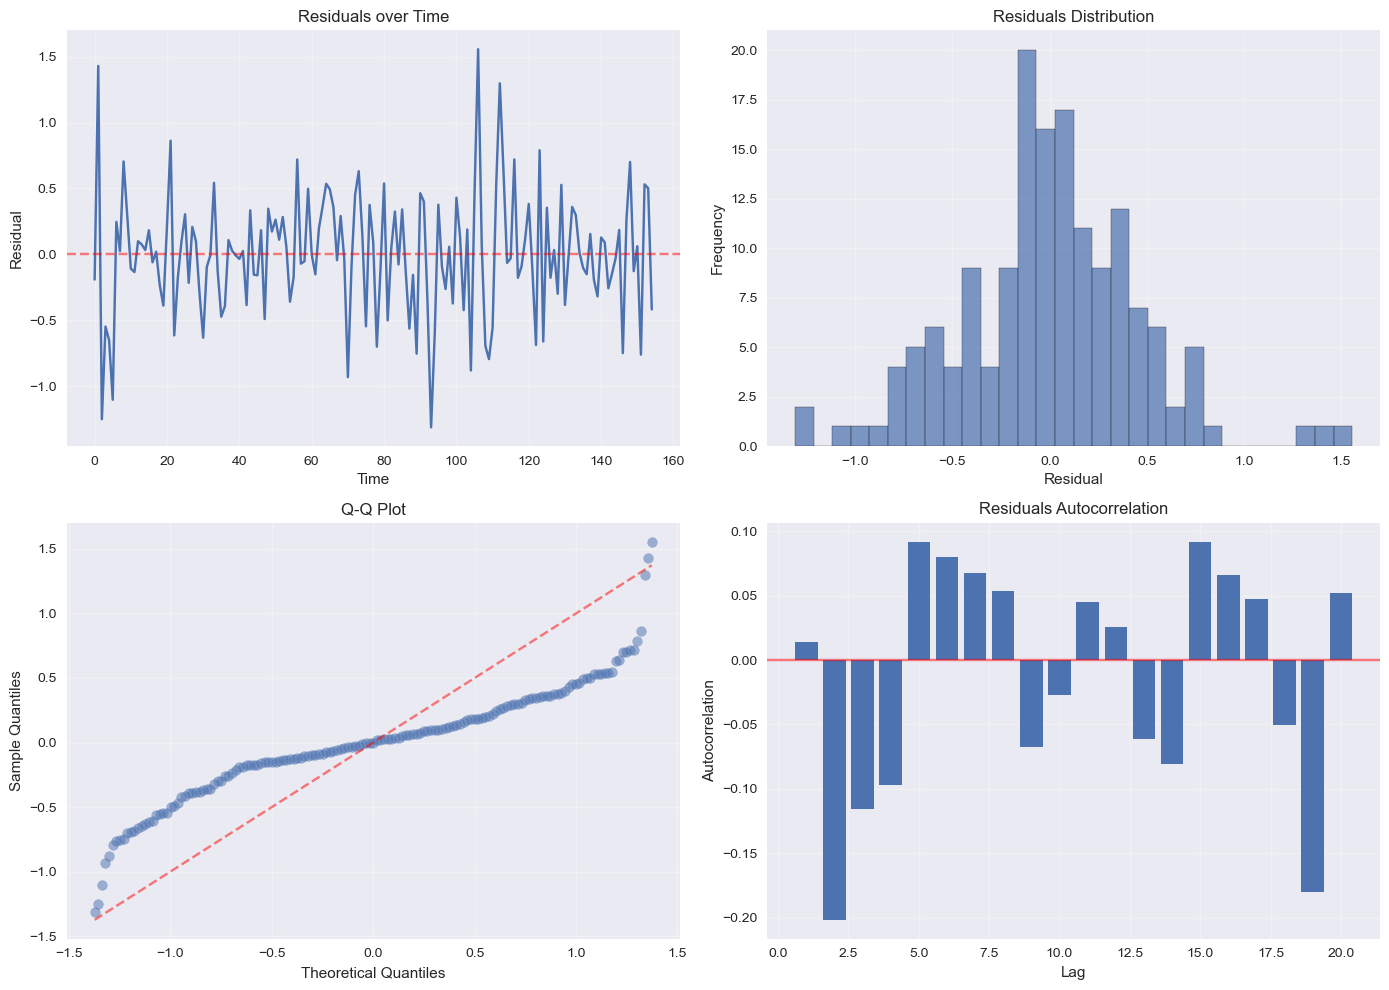

AR(2) (AIC=198.94)


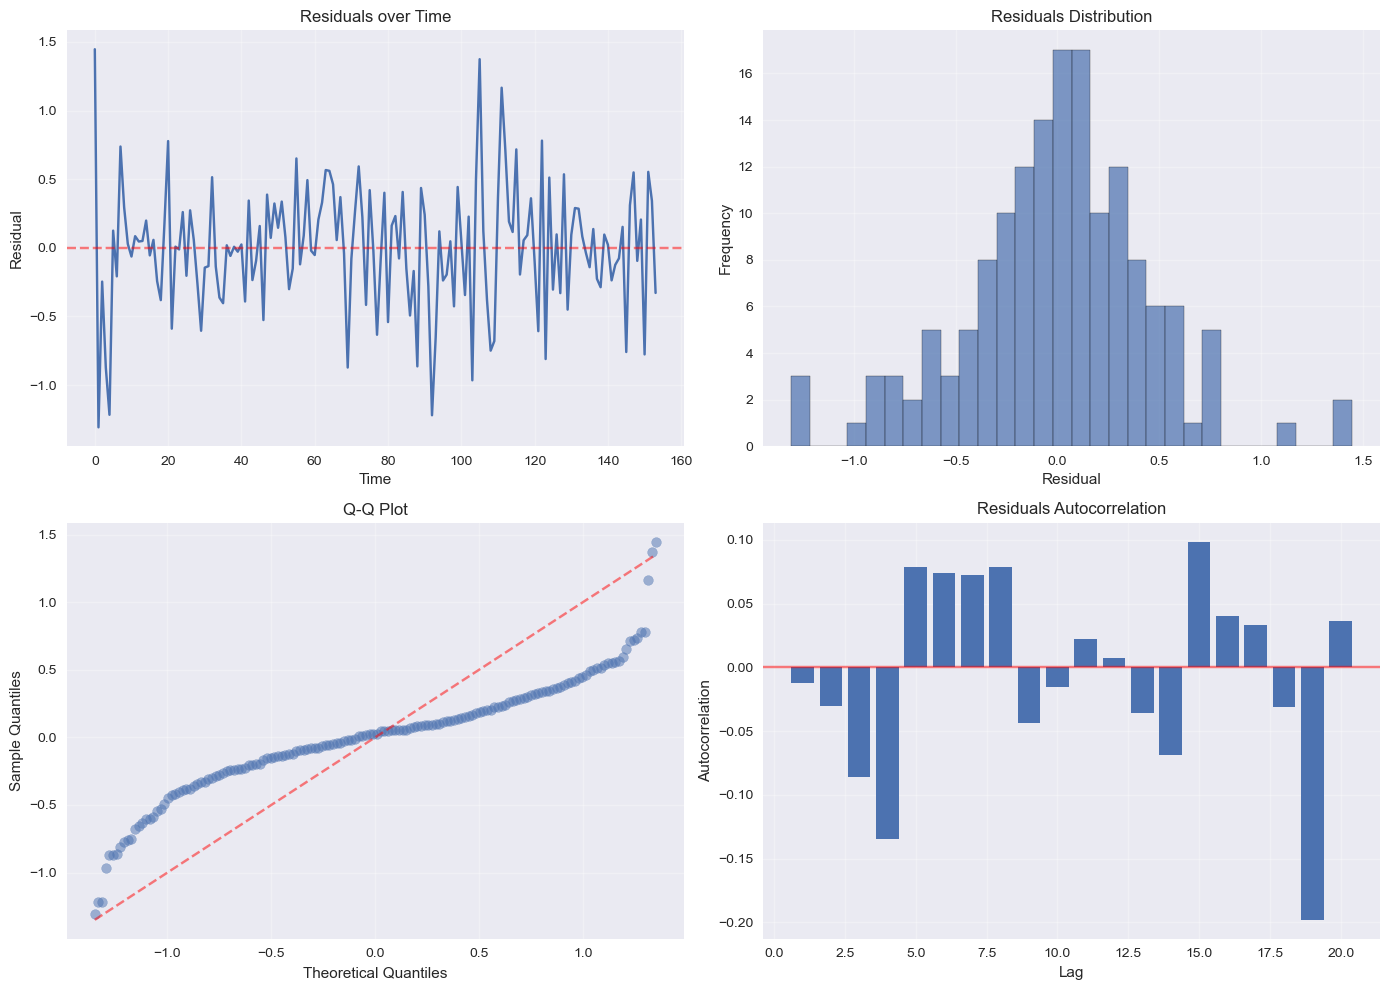

AR(3) (AIC=188.20)


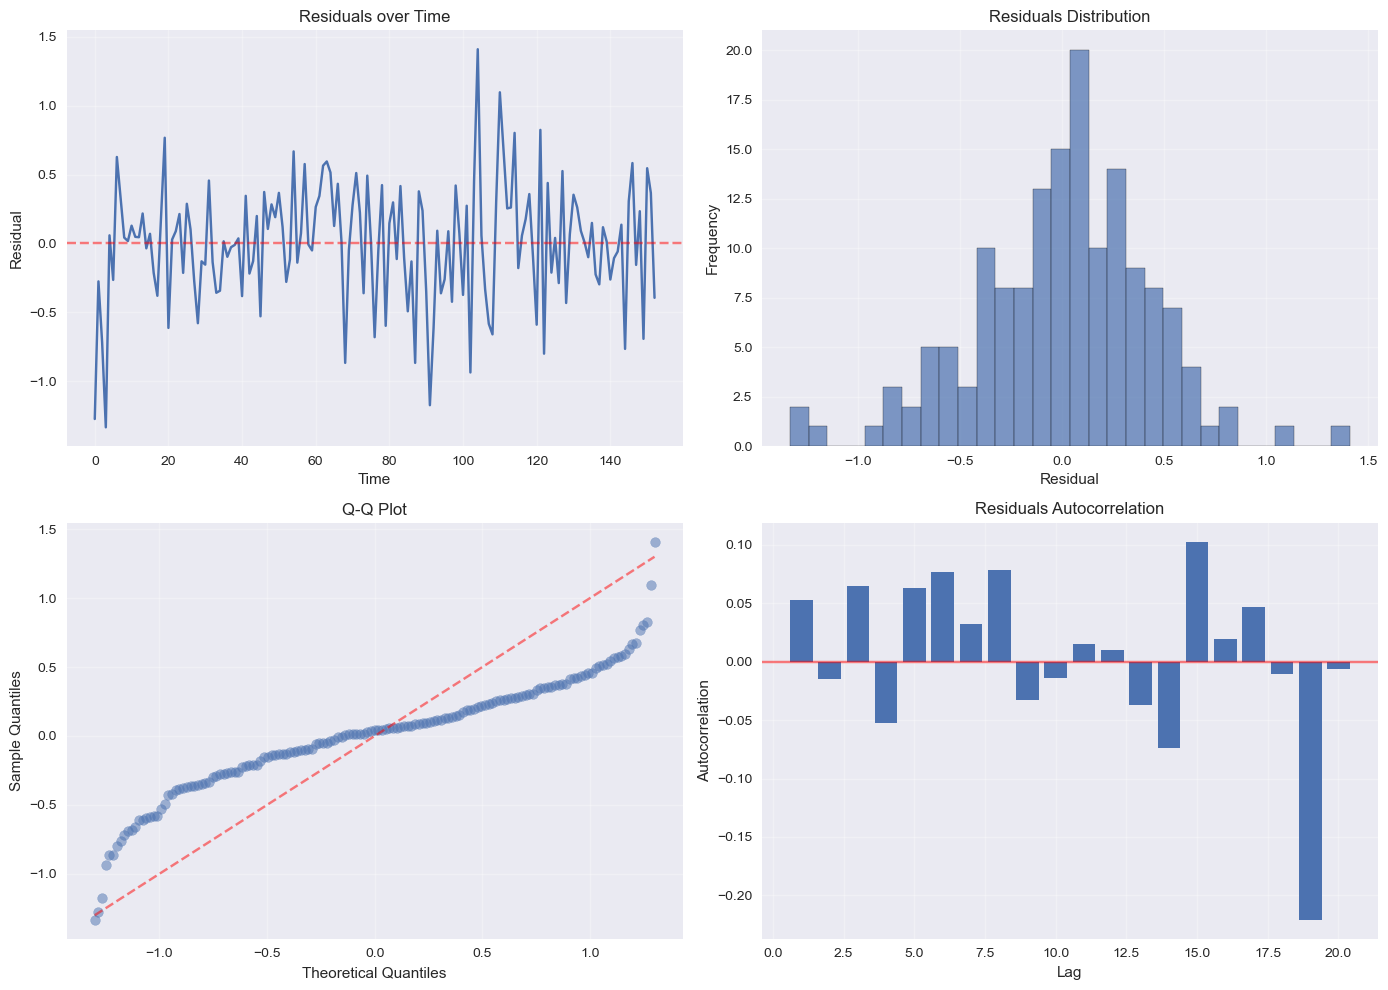

AR(4) (AIC=178.21)


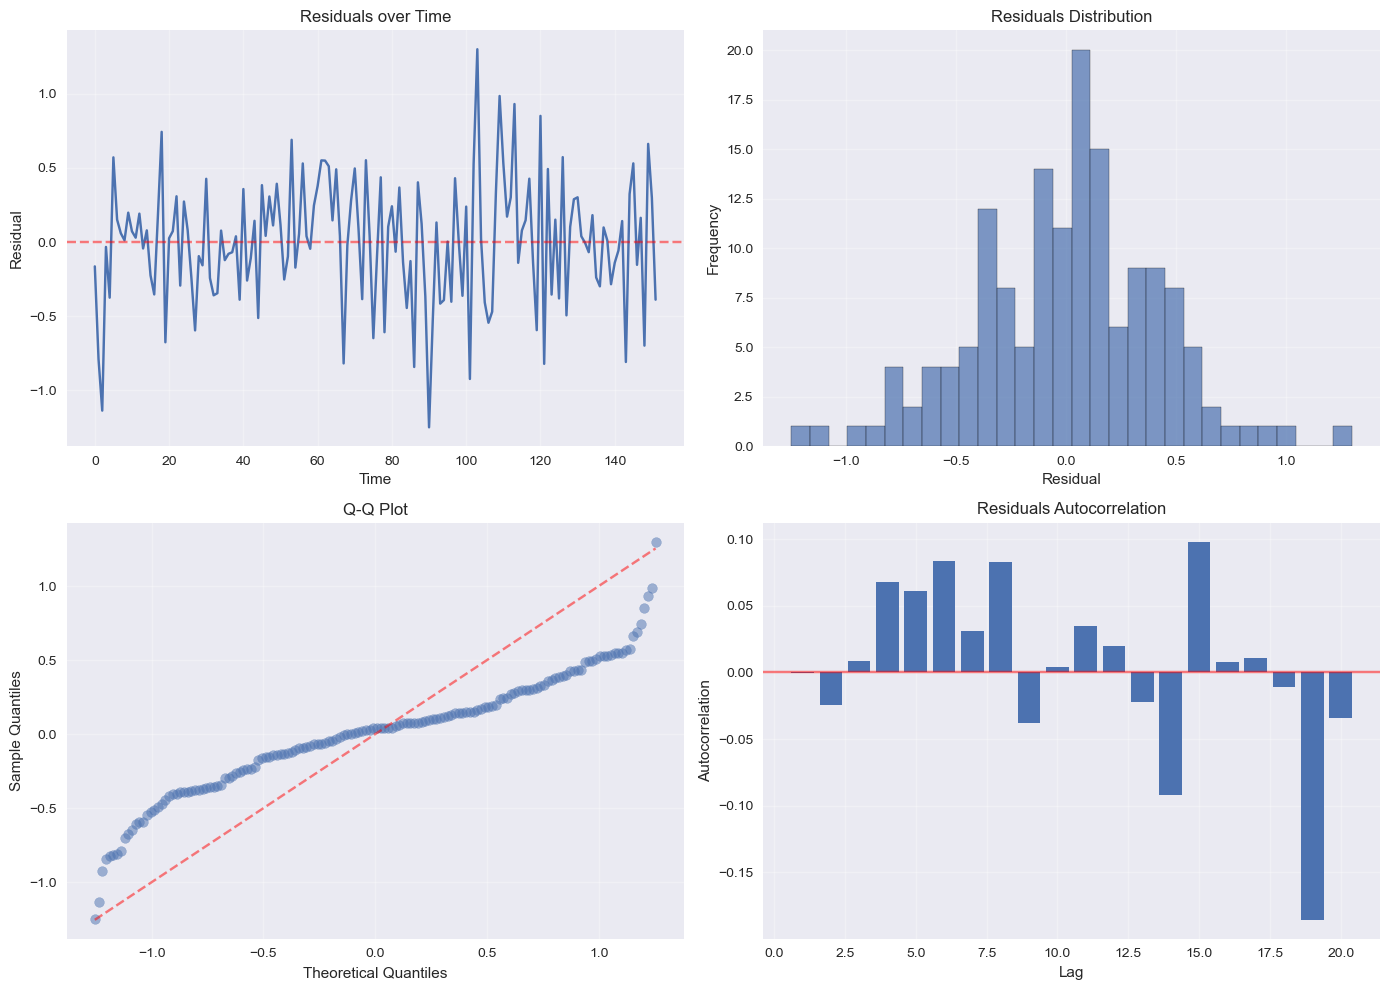

AR(5) (AIC=179.33)


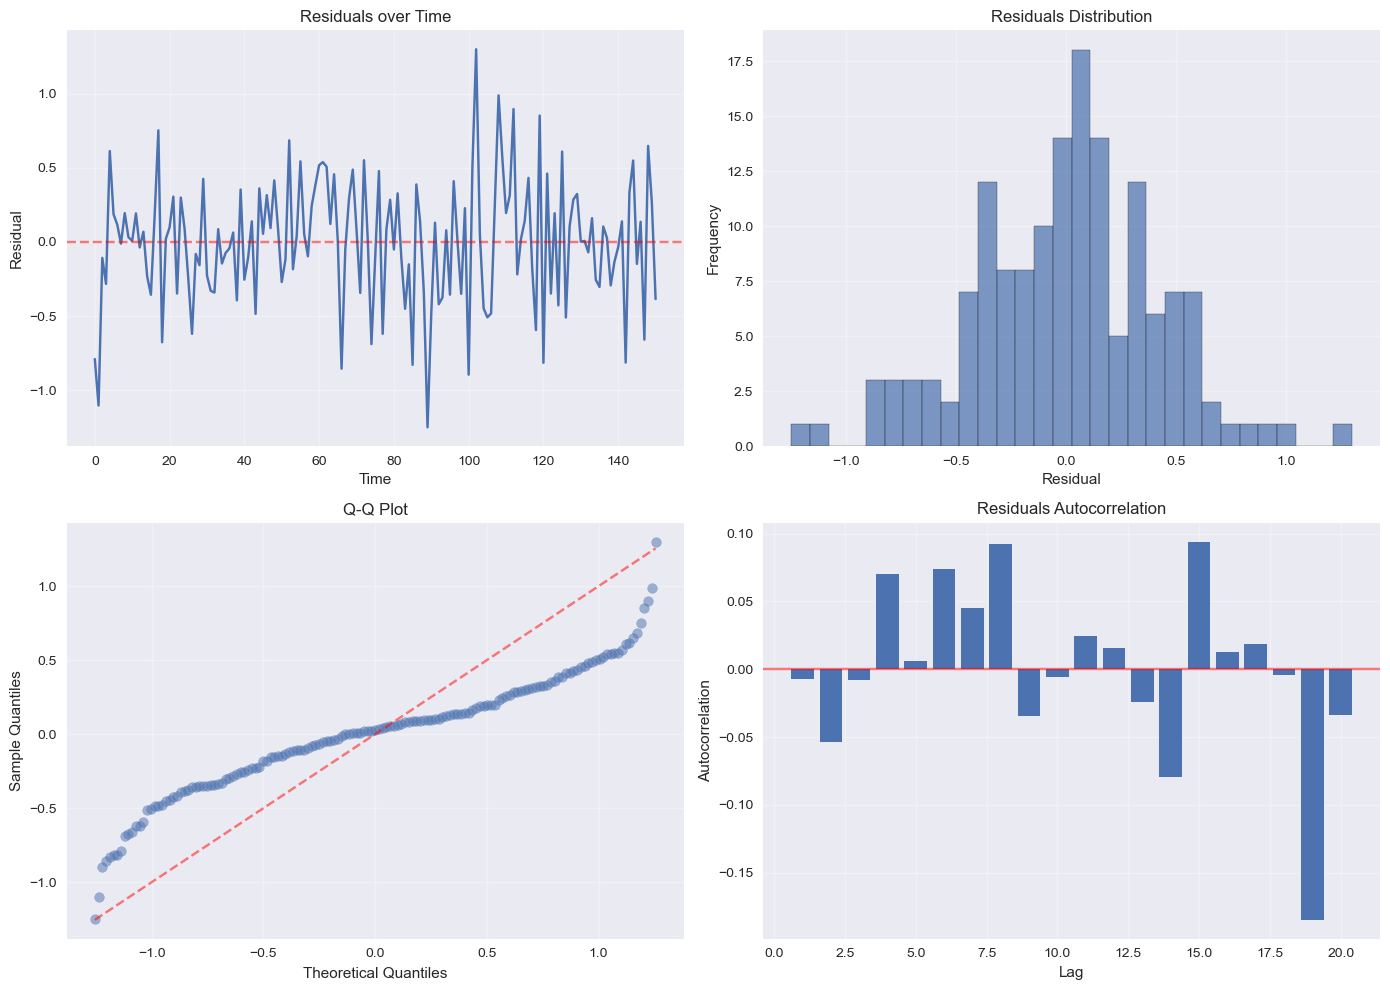


=== Resíduos modelos MA ===
MA(1) (AIC=203.54)


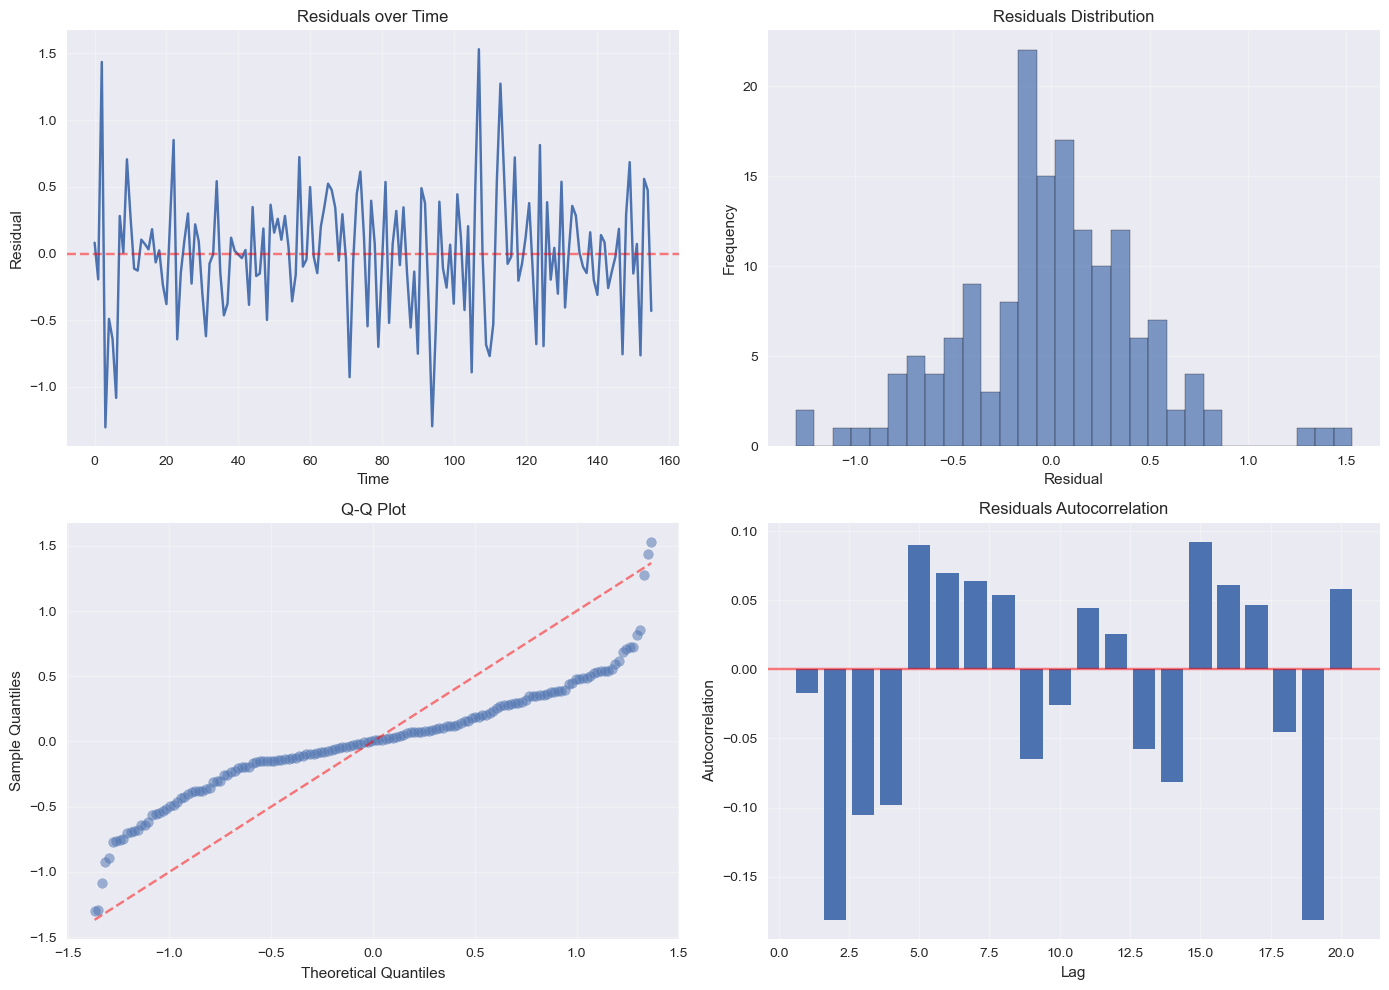

MA(2) (AIC=199.01)


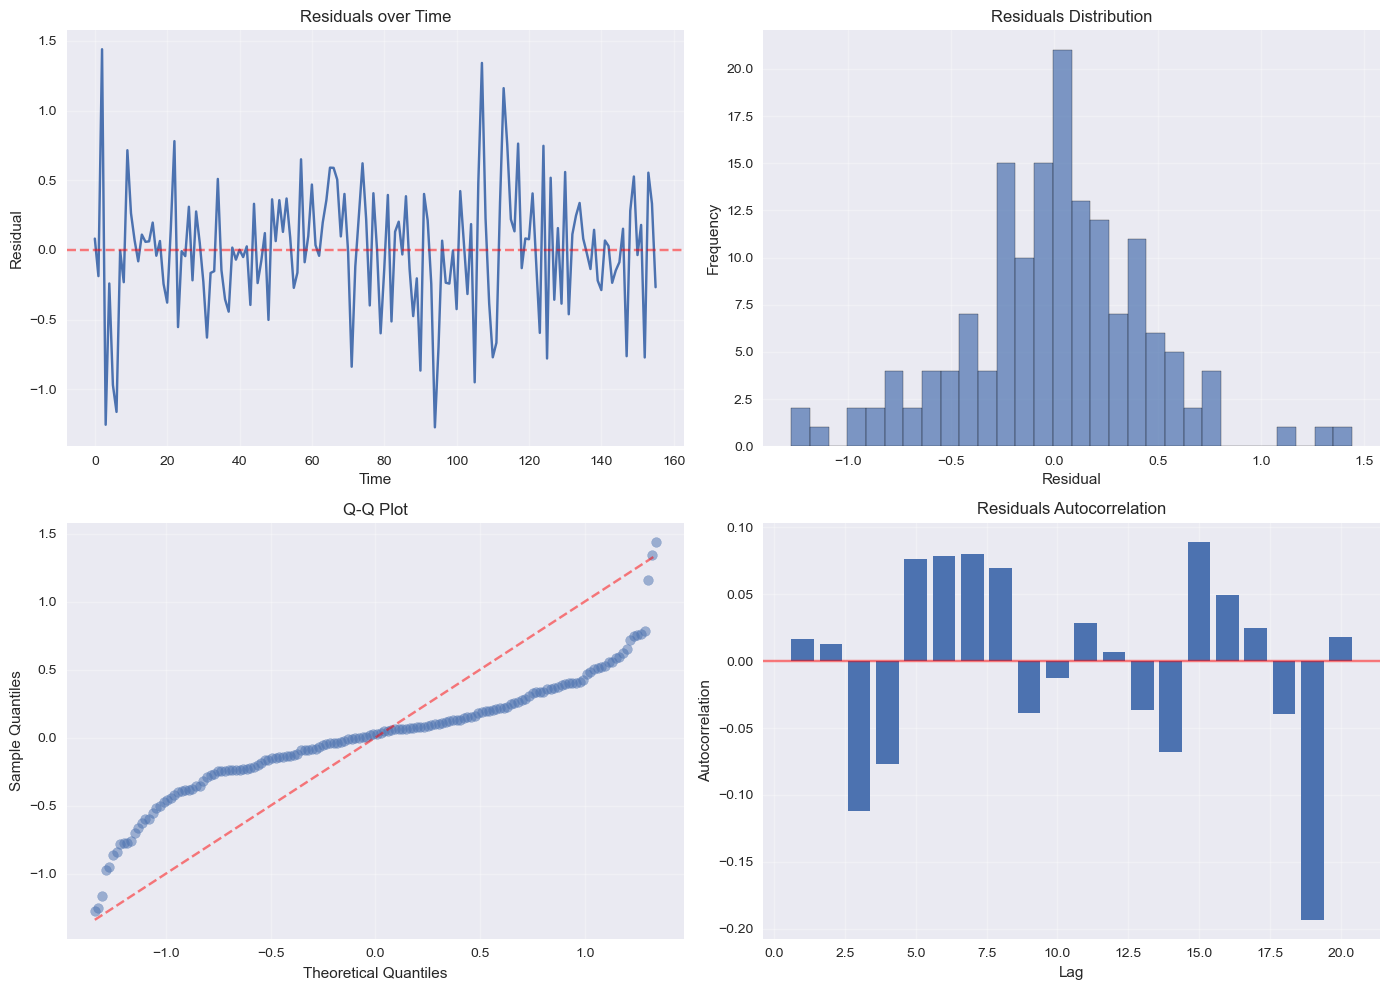

MA(3) (AIC=200.15)


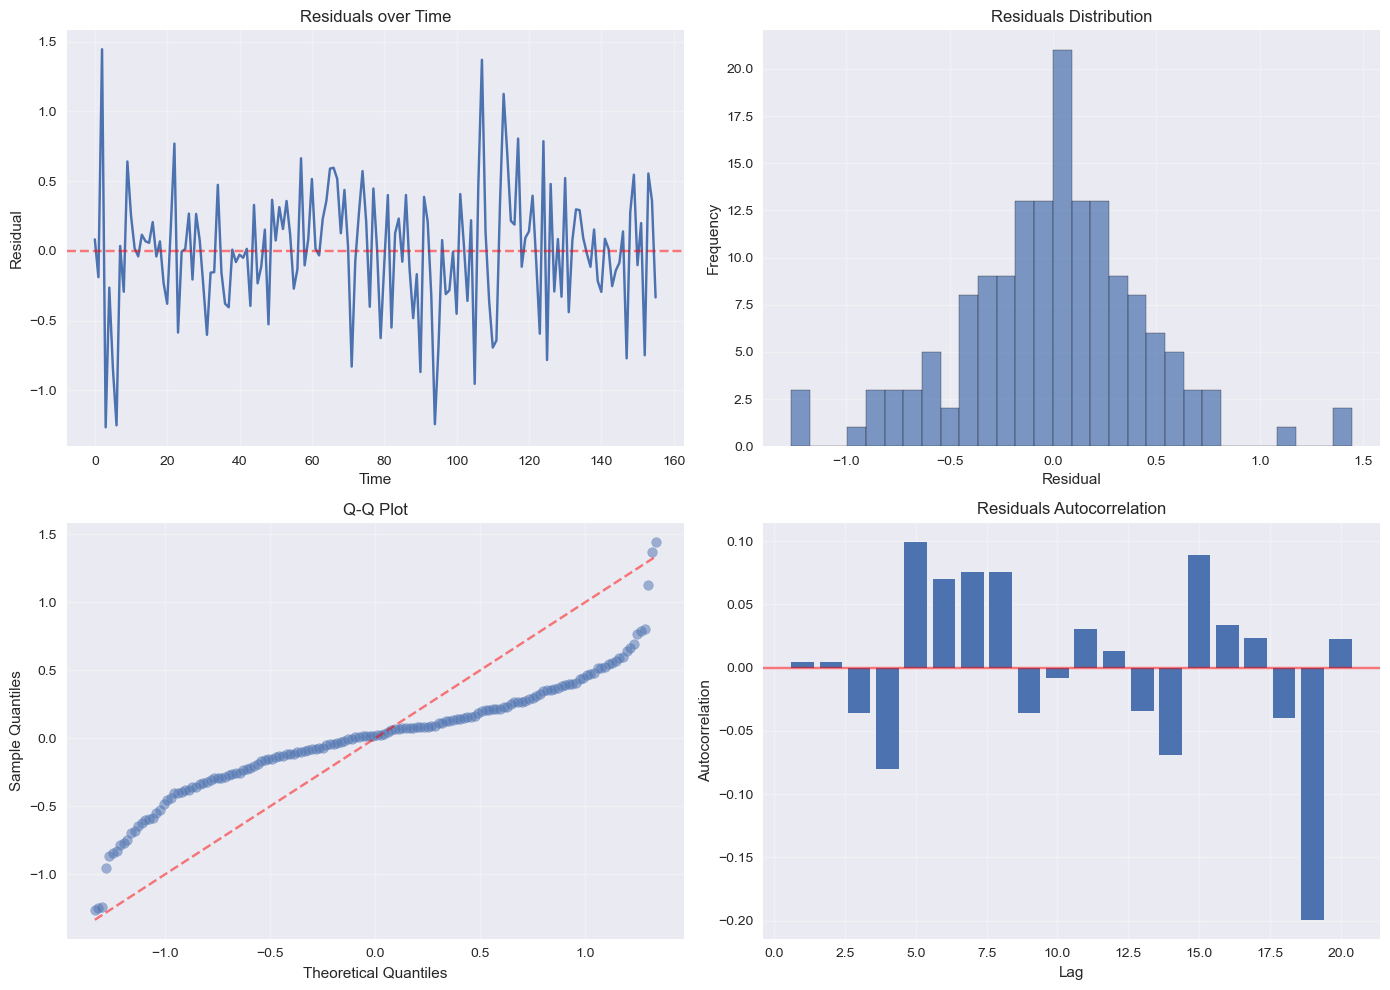

MA(4) (AIC=201.44)


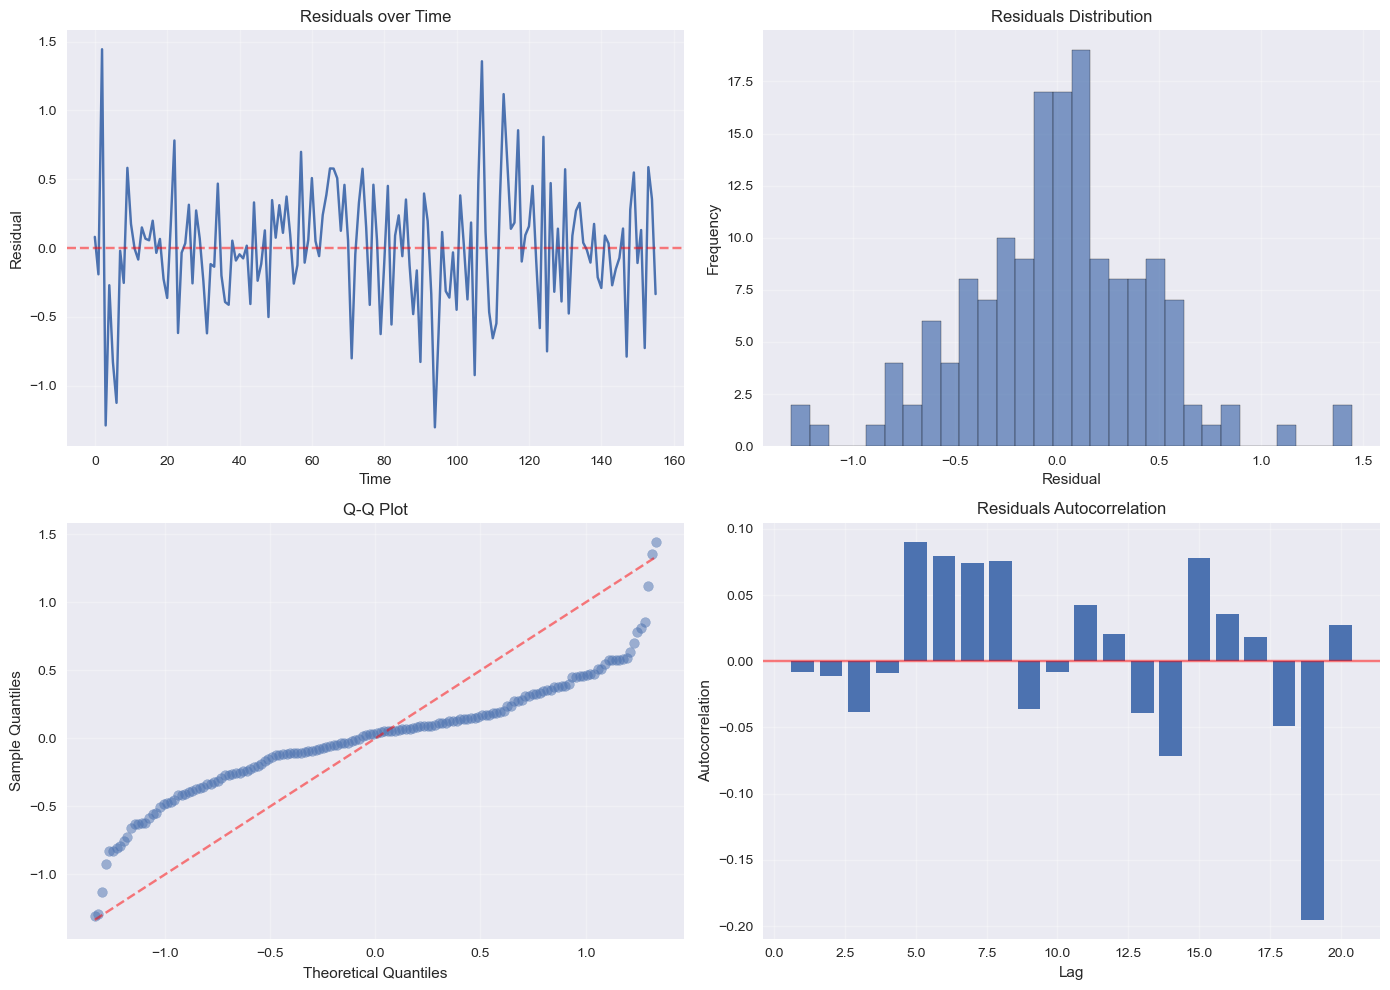

MA(5) (AIC=201.40)


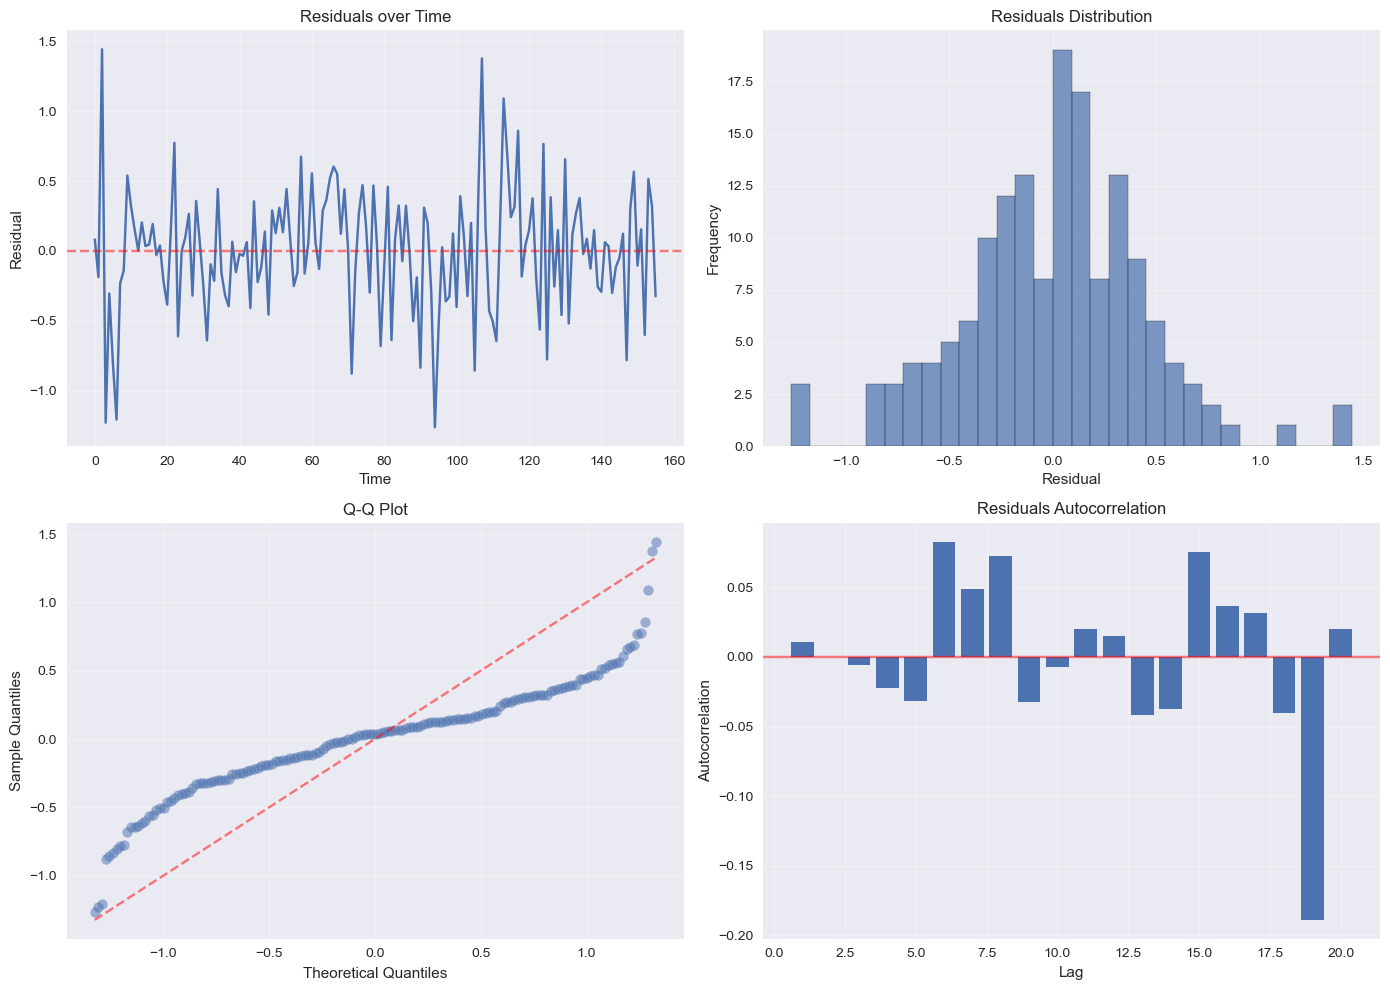


=== Melhor AR ===: lags=4, AIC=178.21
=== Melhor MA ===: order=2, AIC=199.01


In [17]:
best_ar, best_ma = compare_ar_ma_models(y, ar_max_lags=5, ma_max_order=5)